In [103]:
import torch
import torch.nn as nn
import torch.nn.functional as functional
import torch.optim as optim
import torch.utils.data as data
import torch.utils.data.sampler as sampler
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

import mnist_loader

batch_size = 100
train_loader, validation_loader, test_loader = mnist_loader.load_data(batch_size=batch_size)

torch.cuda.is_available()

True

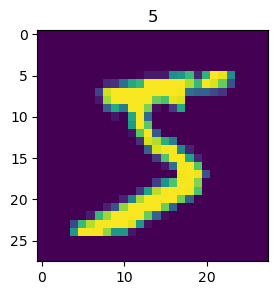

In [104]:
import matplotlib.pyplot as plt

plt.figure(figsize=(3, 3))
plt.title(f"{train_loader.dataset[0][1]}")
plt.imshow(train_loader.dataset[0][0][0])
plt.show()

In [105]:
class Encoder(nn.Module): # Gaussian MLP
  def __init__(self, dim_input, dim_hidden, dim_output):
    super(Encoder, self).__init__()
    self.L1 = nn.Linear(dim_input, dim_hidden)
    self.L_mu = nn.Linear(dim_hidden, dim_output)
    self.L_sig = nn.Linear(dim_hidden, dim_output)
    
  def forward(self, x):
    _h = self.L1(x)
    _h = functional.tanh(_h)
    mu = self.L_mu(_h)
    log_var = self.L_sig(_h)
    return mu, log_var

In [106]:
class Decoder(nn.Module): # Bernoulli MLP
  def __init__(self, dim_input, dim_hidden, dim_output):
    super(Decoder, self).__init__()
    self.L1 = nn.Linear(dim_input, dim_hidden)
    self.L2 = nn.Linear(dim_hidden, dim_output)
    
  def forward(self, z):
    _h = self.L1(z)
    _h = self.L2(functional.tanh(_h))
    return functional.sigmoid(_h)

In [107]:
class Model(nn.Module):
  def __init__(self, encoder: Encoder, decoder: Decoder):
    super(Model, self).__init__()
    self.Encoder = encoder
    self.Decoder = decoder
  
  @staticmethod
  def reparameterization(mu, sig_sqrd):
    epsilon = torch.randn_like(sig_sqrd)
    return mu + sig_sqrd * epsilon
  
  def forward(self, x):
    mu, log_var = self.Encoder(x)
    z = self.reparameterization(mu, torch.exp(1/2 * log_var))
    return self.Decoder(z), mu, log_var
    

In [108]:
encoder = Encoder(28*28, 400, 200)
decoder = Decoder(200, 400, 28*28)
model = Model(encoder, decoder)

print(model)

Model(
  (Encoder): Encoder(
    (L1): Linear(in_features=784, out_features=400, bias=True)
    (L_mu): Linear(in_features=400, out_features=200, bias=True)
    (L_sig): Linear(in_features=400, out_features=200, bias=True)
  )
  (Decoder): Decoder(
    (L1): Linear(in_features=200, out_features=400, bias=True)
    (L2): Linear(in_features=400, out_features=784, bias=True)
  )
)


In [109]:
def elbo_loss(x, x_hat, mu, log_var):
  kl_div = - 1/2 * torch.sum(1 + log_var - torch.pow(mu, 2) - torch.exp(log_var))
  reproduction_loss = functional.binary_cross_entropy(x_hat, x, reduction='sum')
  return reproduction_loss + kl_div

In [110]:
optimizer = optim.Adam(model.parameters(), lr = 0.001)

epochs = 30

for epoch in range(epochs):
    print(f"epoch {epoch}")
    
    total_loss = 0.
    
    for i, (X, y) in enumerate(train_loader):
        model.train()
        X = X.view(batch_size, 784)
        X_hat, mu, log_var = model(X) # training mode
        loss = elbo_loss(X, X_hat, mu, log_var)
        total_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
    print(f"training loss: {total_loss / len(train_loader)}")
        

epoch 0
training loss: 18257.88051106771
epoch 1
training loss: 14252.888872070313
epoch 2
training loss: 12685.99151529948
epoch 3
training loss: 12016.94051920573
epoch 4
training loss: 11633.173577473959
epoch 5
training loss: 11398.687856445313
epoch 6
training loss: 11244.517174479166
epoch 7
training loss: 11126.300600585937
epoch 8
training loss: 11033.777540690104
epoch 9
training loss: 10945.958899739584
epoch 10
training loss: 10881.832662760416
epoch 11
training loss: 10825.160354817708
epoch 12
training loss: 10774.910073242187
epoch 13
training loss: 10738.960291341145
epoch 14
training loss: 10704.262788085938
epoch 15
training loss: 10675.34875
epoch 16
training loss: 10639.232652994791
epoch 17
training loss: 10623.350460611979
epoch 18
training loss: 10597.912680664063
epoch 19
training loss: 10582.796606445312
epoch 20
training loss: 10570.559611002604
epoch 21
training loss: 10546.448115234374
epoch 22
training loss: 10534.267112630208
epoch 23
training loss: 10525.9

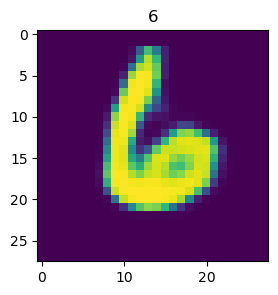

In [128]:
z_test = []
with torch.no_grad():
  for j, (test_X, test_y) in enumerate(test_loader):
    test_X = test_X.view(1, 784)
    z, _, _ = model(test_X)
    z_test.append((z.view(28, 28), test_y))

plt.figure(figsize=(3, 3))
plt.title(f"{z_test[0][1].item()}")
plt.imshow(z_test[0][0])
plt.show()